This version of chatbot is taken and modified from commit: [#862c1b6](https://github.com/MahirHamiAbrar/IntelliTube/blob/862c1b6ffbeff7507b3683de390d3afe8d45c5c1/chatbot.ipynb).

## Initialize a new Chat

In [19]:
from intellitube.utils import ChatHistoryManager
chat: ChatHistoryManager = ChatHistoryManager.new_chat()
print(f"Chat ID:", chat.chat_id)
chat.remove_unlisted_chats()

2025-07-10 18:25:36.686 | WARNING  | intellitube.utils.chat_history:remove_unlisted_chats:205 - Removing Unlisted Chat: ebe0960e-eec1-4253-80aa-d870bce63e8d


Chat ID: f04425c9-aef0-4895-834c-371d9d35fcf8


## Initialize the RAG System
Using `TextDocumentRAG()` from `intellitube.rag` module automatically initializes `Qdrant` client as Vector Database.

In [2]:
import os
from typing import List
from intellitube.rag import TextDocumentRAG
from langchain_core.documents import Document

document_rag = TextDocumentRAG(
    path_on_disk=chat.chat_dirpath,
    collection_path_on_disk=os.path.join(chat.chat_dirpath, "collection"),
    collection_name=chat.chat_id,
)

def add_to_vdb(docuemnts: List[Document]) -> None:
    # convert to a list of document(s) if not already!
    if type(docuemnts) == Document:
        docuemnts = [docuemnts]
    
    document_rag.add_documents(
        docuemnts, split_text=True,
        split_config={
            "chunk_size": 512,
            "chunk_overlap": 128
        },
        skip_if_collection_exists=True,
    )

2025-07-10 18:22:52.140 | DEBUG    | intellitube.rag:init_vector_store:66 - Creaing Client...
2025-07-10 18:22:52.150 | DEBUG    | intellitube.rag:init_vector_store:73 - Creaing vector store


## Create Document Loader Tools

In [3]:
from langchain.tools import tool

### 1. Add YouTube Videos to the Vector Database

In [4]:
from intellitube.utils import (
    YTContentData,
    webvtt_2_str,
    download_youtube_audio_or_transcript,
)

test_url = "https://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s"

@tool
def load_youtube_transcript(youtube_url: str) -> str:
    """Load the given YouTube video's transcript to the vector database.
    It is required to answer user-queries based on the the Transcript context."""

    print("Loading Youtube Transcript...")
    
    # download the youtube transcript (or audio if transcript not available)
    yt_video_data: YTContentData = download_youtube_audio_or_transcript(
        video_url=youtube_url,
    )

    # convert the WEBVTT format trancript to a plain text string
    vtt_str = webvtt_2_str(vtt_file_path=yt_video_data.transcript_path)
    
    print(vtt_str[:100])    # print first 100 characters

    # add the transcript-string to the vector database
    add_to_vdb(Document(vtt_str))
    return "YouTube Video Transcript has been loaded successfully!"

### 2. Add PDF/Text Documents to the Vector Dataabse

In [5]:
import os
from langchain_community.document_loaders import PyPDFLoader


@tool
def load_document(document_path: str) -> str:
    """Load the given Document's content to the vector database.
    It is required to answer user-queries based on the the Document context."""
    print("Loading Document...")
    
    ext = os.path.splitext(document_path)[1][1:].lower()
    documents: List[Document]

    if ext == 'pdf':
        documents = PyPDFLoader(document_path).load()
    elif ext == 'txt':
        with open(document_path, 'r') as file:
            documents = [Document(
                page_content=file.read(),
                metadata={ "source": document_path }
            )]
    else:
        return f"Unsupported filetype: {ext}!"
    
    add_to_vdb(documents)
    return "The document has been loaded successfully!"
        

### 3. Add WebPages as Documents to the Vector Dataabse

In [6]:
from langchain_community.document_loaders import WebBaseLoader

@tool
def load_webpage(webpage_url: str) -> str:
    """Load the given WebSite's content to the vector database.
    It is required to answer user-queries based on the the WebPage's context."""

    add_to_vdb(WebBaseLoader(webpage_url).load())
    print("Loading Webpage...")
    return "The webpage has been loaded successfully!"

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Pass the Query Tool
This is a function to be called by the Agent if none of the other tools can be used.

In [7]:
@tool
def pass_user_query(user_query: str) -> None:
    """Use this tool when none of the other tools are useful."""
    print(f"Passes User Query: {user_query}")
    return f"User: {user_query}"

#### Finally, compile a list of the tools

In [8]:
document_loader_tools = [load_youtube_transcript, load_document, load_webpage, pass_user_query]

from pprint import pprint
pprint(document_loader_tools)

[StructuredTool(name='load_youtube_transcript', description="Load the given YouTube video's transcript to the vector database.\n    It is required to answer user-queries based on the the Transcript context.", args_schema=<class 'langchain_core.utils.pydantic.load_youtube_transcript'>, func=<function load_youtube_transcript at 0x7f7279a02ca0>),
 StructuredTool(name='load_document', description="Load the given Document's content to the vector database.\n    It is required to answer user-queries based on the the Document context.", args_schema=<class 'langchain_core.utils.pydantic.load_document'>, func=<function load_document at 0x7f7279a4b4c0>),
 StructuredTool(name='load_webpage', description="Load the given WebSite's content to the vector database.\n    It is required to answer user-queries based on the the WebPage's context.", args_schema=<class 'langchain_core.utils.pydantic.load_webpage'>, func=<function load_webpage at 0x7f738a7e0900>),
 StructuredTool(name='pass_user_query', descr

## Choose an LLM

In [9]:
from typing import Literal, Optional
# from langchain.chat_models import init_chat_model
from langchain_core.language_models import BaseChatModel

from dotenv import load_dotenv
load_dotenv()

def select_llm(
    model_provider: Literal['openai', 'groq', 'nvidia', 'google', 'ollama'],
    model_name: Optional[str] = None,
    temperature: float = 0.0,
) -> BaseChatModel:
    if model_provider == 'openai':
        from langchain_openai import ChatOpenAI
        return ChatOpenAI(model=model_name or "gpt-4o-mini", temperature=temperature)
    elif model_provider == 'groq':
        from langchain_groq import ChatGroq
        return ChatGroq(model=model_name or "llama-3.3-70b-versatile", temperature=temperature)
    elif model_provider == 'nvidia':
        from langchain_nvidia_ai_endpoints import ChatNVIDIA
        # return ChatNVIDIA(model=model_name or "mistralai/mistral-small-24b-instruct", temperature=temperature)
        return ChatNVIDIA(model=model_name or "nvidia/llama-3.1-nemotron-51b-instruct", temperature=temperature)
    elif model_provider == 'google':
        from langchain_google_genai import ChatGoogleGenerativeAI
        return ChatGoogleGenerativeAI(model=model_name or "gemini-2.0-flash", temperature=temperature)
    elif model_provider == 'ollama':
        from langchain_ollama import ChatOllama
        # return ChatOllama(model=model_name or "granite3.3:8b", temperature=temperature)
        return ChatOllama(model=model_name or "llama3.2:3b", temperature=temperature)
    
    raise ValueError(f"Invalid model_provider: {model_provider}")

#### Test the LLM

In [10]:
TEST_LLM = False
llm = select_llm(model_provider='google')
# llm = select_llm(model_provider='ollama')

if TEST_LLM:
    resp = llm.invoke("What is superiority complex? Respond with a nicely structured & formatted answer!")
    print(resp)
    
    from IPython.display import display, Markdown
    display(Markdown(resp.content))

## Define State Schema

### Messages State Schema

In [11]:
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from typing_extensions import Annotated, Sequence, TypedDict

class MessagesState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## Create Nodes

### Router Node
This router will decide if the user has provided any Document/Website URL/YouTube URL. Depending on the type of URL it will call a function to load the document or just redirect the query to a RAG Agent for direct response generation if no URL is provided.

In [12]:
from langchain_core.messages import AIMessage, SystemMessage


def router_agent_node(state: MessagesState) -> MessagesState:
    user_query: str = state["messages"][-1].content
    tools_llm = llm.bind_tools(tools=document_loader_tools)
    
    system_prompt = SystemMessage(
f"""You are a very helpful assistant. You have access to {len(document_loader_tools)} tools.

Here is when to use which tool:
    - load_youtube_transcript: To load an YouTube Video's transcript
    - load_document: To load a Text/PDF document (can be a local path)
    - load_webpage: To laod an WebPage
    - pass_user_query: When you find no URL/Path in the user query

Here is the user query: {user_query}

Observe the user query and if you see any URL/Path of a file/document/YT Video/Website use the necessary tool to load it.
If you see no URL then just use the `pass_user_query` tool to pass the query to the next Agent.

You MUST use ONE of the above tools. DO NOT generate any extra text beyond what's instructed.
    """)

    ai_msg: AIMessage = tools_llm.invoke([system_prompt] + state["messages"])
    # Validate id the ai_msg has tool calls (IT MUST)
    # ...
    return {"messages": [ai_msg]}

In [13]:
TEST_DOC_LOAD_ROUTER = False

if TEST_DOC_LOAD_ROUTER:
    queries = [
        # Website URL
        "What is the model name mentioned?\nhttps://build.nvidia.com/nvidia/llama-3_1-nemotron-51b-instruct",
        # YouTube URL
        "What do you see here?\nhttps://www.youtube.com/watch?v=W3I3kAg2J7w&t=231s",
        # Local Document Path
        "Summarize this document: ~/data.json",
        # Just a normal Query
        "Why oranges are red and violates are blue?"
    ]

    for i, query in enumerate(queries):
        print("-"*15, f"Test {i + 1}", "*"*15, end='\n\n')
        response = router_agent_node(user_query=query)
        print("\n\n")

### Chat Agent Node

In [14]:
def chat_agent_node(state: MessagesState) -> MessagesState:
    """A Chat Agent"""
    system_prompt = SystemMessage("""You are IntelliTube AI, a smart research parter for the user.""")
    ai_msg: AIMessage = llm.invoke([system_prompt] + state["messages"])
    return {"messages": [ai_msg]}

## Create the Agent

In [15]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END, StateGraph

graph = (
    StateGraph(state_schema=MessagesState)
    .add_node("router_agent", router_agent_node)
    .add_node("tools", ToolNode(tools=document_loader_tools))
    .add_node("chat_agent", chat_agent_node)
    .add_edge(START, "router_agent")
    .add_edge("router_agent", "tools")
    .add_edge("tools", "chat_agent")
    .add_edge("chat_agent", END)
)

agent = graph.compile()

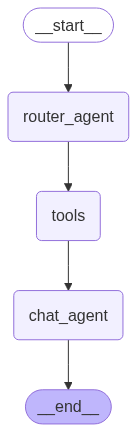

In [16]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

## Chat Function

In [17]:
from langchain_core.messages import HumanMessage

def chat_loop() -> None:
    usr_msg: str = input(">> ").strip()

    while usr_msg.lower() != "/exit":
        usr_msg = HumanMessage(usr_msg)
        chat.add_message(usr_msg)
        chat.chat_messages = agent.invoke({"messages": chat.chat_messages})["messages"]
        ai_msg: AIMessage = chat.chat_messages[-1]
        ai_msg.pretty_print()
        usr_msg: str = input(">> ").strip()
    chat.end_chat()

In [18]:
chat_loop()

Passes User Query: hi
================================== Ai Message ==================================

Hi there! How can I help you today? Are you looking to research a specific topic, analyze a YouTube video, or something else? Let me know what you have in mind!


2025-07-10 18:23:25.334 | INFO     | intellitube.rag:add_documents:96 - Splitting text...
2025-07-10 18:23:25.336 | INFO     | intellitube.rag:add_documents:100 - Adding documents...


Loading Webpage...
================================== Ai Message ==================================

Okay, I've loaded the content from the Langchain page on "Structured Outputs."  Based on the page, here's what it covers:

**Key Concepts and Purpose:**

*   **Structured Outputs:** The core idea is to get Langchain models to return data in a predictable, structured format (like a JSON object) instead of just free-form text. This makes it much easier to use the output in downstream applications, code, or other parts of your workflow.

*   **Why Use Structured Outputs?**
    *   **Reliability:**  Guarantees the output will conform to a specific schema.
    *   **Usability:**  Makes it simple to parse and use the information programmatically.
    *   **Validation:**  Allows you to validate the output against the schema to ensure data quality.

**How to Achieve Structured Outputs (Techniques and Tools):**

*   **Output Parsers:** Langchain provides output parsers that define the structure 